# Canonical correlation analysis on SSVEP dataset

In [63]:
!pip install mne==1.2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import create_info
from mne.io import RawArray
from mne.time_frequency import psd_welch

## 1. Loading the data

In [61]:
df = pd.read_csv('ssvep-10trials-3s-chaky-bigsquare.csv')
df.rename(columns={'Unnamed: 1':'O1','Unnamed: 2':'Oz', 'Unnamed: 3':'O2'}, inplace=True)
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

In [62]:
df.head()

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


Let's rename our channel

In [44]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,24727.394,58600.641,53608.289,49404.219,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
1,24727.394,58582.133,53588.531,49381.977,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
2,24727.395,58619.953,53622.977,49414.520,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
3,24727.395,58660.992,53663.207,49452.832,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
4,24727.395,58645.566,53651.676,49443.469,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0


Let's drop the channel we did not use.

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


So in our dataset, we got three targets flashing at 6Hz, 10Hz, and 15Hz.  Each target happens 10 times.  They are represented by label of 1, 2, 3 respectively.

In [47]:
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz
print(df[df.Marker==3].shape) #15hz

(10, 4)
(10, 4)
(10, 4)


In [48]:
df[df.Marker==3]

,O1,Oz,O2,Marker
4297,58866.090,53230.211,50417.914,3
7319,59772.500,54168.223,51649.965,3
10340,59248.820,53769.758,52020.242,3
13362,59843.266,54835.691,53074.082,3
16397,59973.105,54223.836,53640.051,3
19418,60740.484,55695.766,54515.793,3
22439,62516.734,57817.930,56554.496,3
25461,62441.297,56799.383,56144.004,3
28482,61106.605,54857.617,54712.129,3
31503,62116.301,55125.684,54010.219,3


## 2. Transform Data into Raw MNE object

In [49]:
def df_to_raw(df):
    sfreq = 125  #our OpenBCI headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T  #mne looks at the tranpose() format
    df[:-1] *= 1e-6  #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)   

    return raw

In [50]:
raw = df_to_raw(df)

Creating RawArray with float64 data, n_channels=4, n_times=32952
    Range : 0 ... 32951 =      0.000 ...   263.608 secs
Ready.


Effective window size : 2.048 (s)


C:\Users\Jamshid\miniconda3\Lib\site-packages\mne\viz\utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


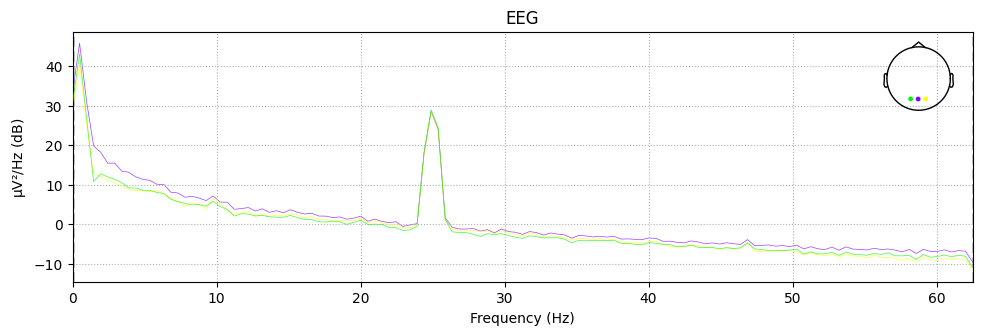

In [51]:
 raw.compute_psd().plot()

## 3. Preprocessing

### Notch Filter

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 825 samples (6.600 sec)

Effective window size : 2.048 (s)


C:\Users\Jamshid\miniconda3\Lib\site-packages\mne\viz\utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


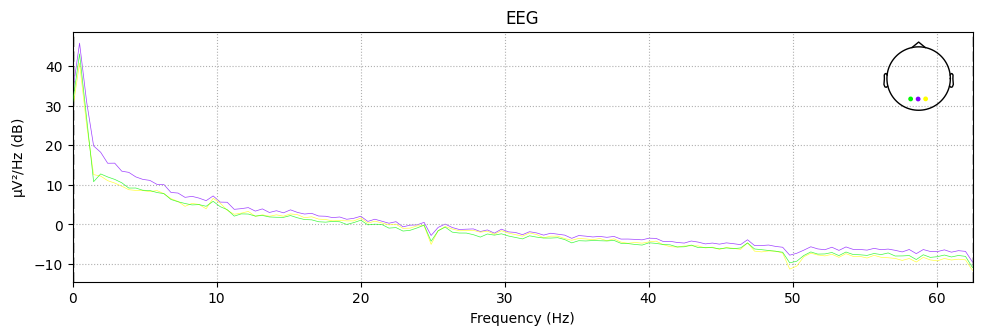

In [52]:
raw.notch_filter([25, 50], filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.compute_psd().plot()

### Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 62 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 62.00 Hz: -6.02, -6.02 dB

Effective window size : 2.048 (s)


C:\Users\Jamshid\miniconda3\Lib\site-packages\mne\viz\utils.py:137: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


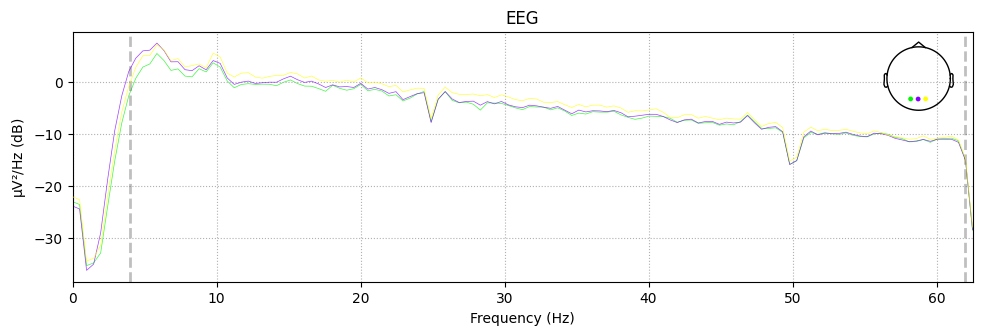

In [53]:
#since we use 6hz, 10hz, and 15hz, 
#we will take five harmonics, which maximum freq is 15 x 4 = 60
#we will take +- 2 at each end, thus 6-2 = 4, and 60+2 = 62
#these numbers are made up by me; you can try different numberes
raw.filter(4, 62, method='iir')

#this should also automatically remove any slow drift under 1Hz
raw.compute_psd().plot()

## 3. Epoching

In [16]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [17]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2, '15Hz' : 3}
tmin=-0.5
tmax=3
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks=picks)

30 events found
Event IDs: [1 2 3]
sample drop %:  0.0


## 4. EDA: Checking stimuli-specific PSD

Effective window size : 8.224 (s)
Effective window size : 8.224 (s)
Effective window size : 8.224 (s)


<decorator-gen-201>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function psd_welch() is deprecated; for Raw/Epochs/Evoked instances use spectrum = instance.compute_psd(method="welch") instead, followed by spectrum.get_data(return_freqs=True)..


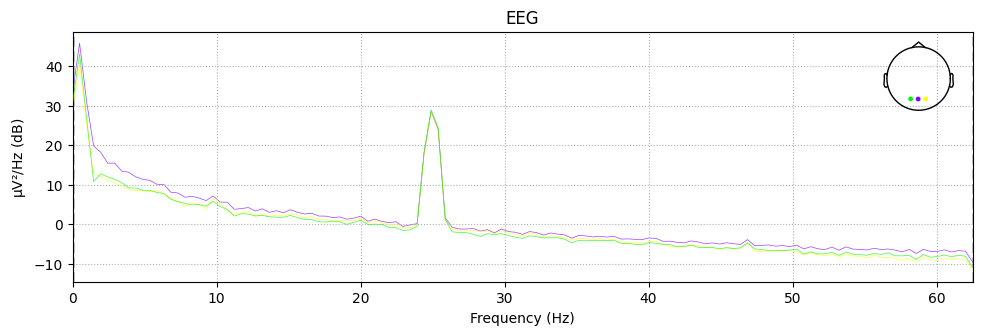

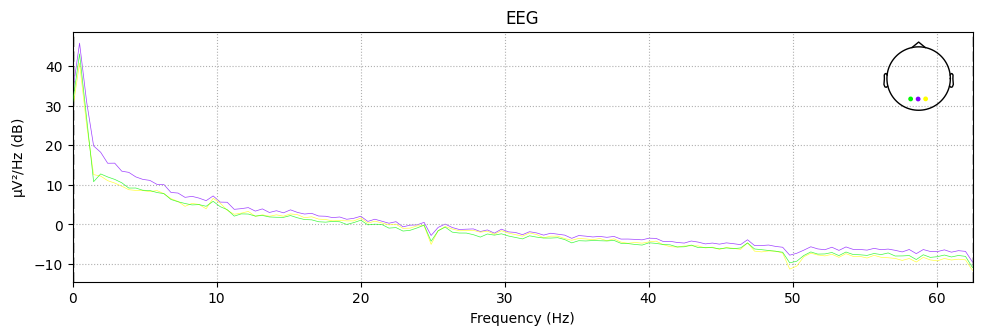

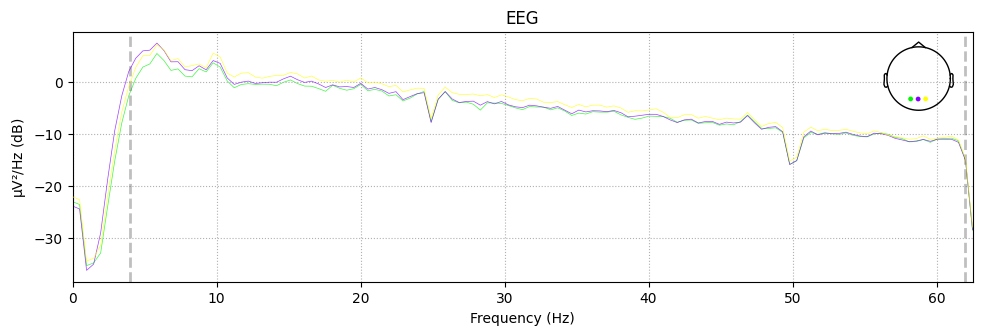

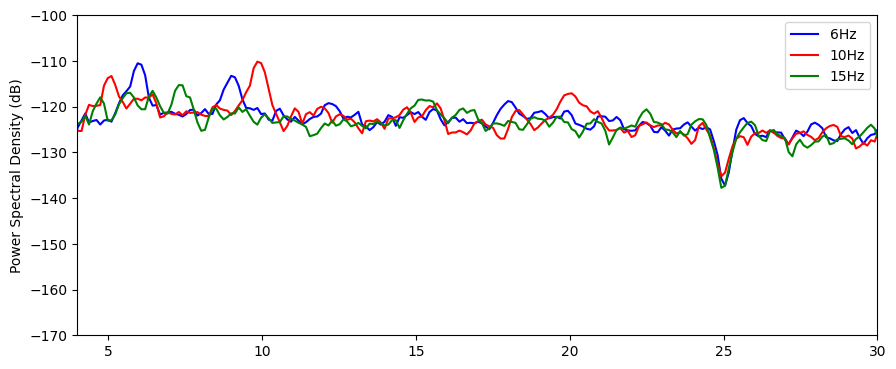

In [54]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
logpsd3 = 10 * np.log10(psd3)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

log_psd3_mean = logpsd3.mean(0)
log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0,2], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0,2], :].mean(0), color='r', label='10Hz')
axes.plot(freq2, log_psd3_mean[[0,2], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim(4, 30)
axes.set_ylim(-170, -100)
axes.legend()

plt.show()

As we can see, we can see the stimuli specific PSDs oscillating at its frequencies and harmonics.

## 5. Canonical Correlation Analysis

Canonical correlation analysis is likely the most standard process to analyze which stimuli belongs to which frequency.  Even it is a very old technique, but it works great here.

Note: The code below may look hard, but once you look closely, it's not really hard.

In [55]:
import scipy
from scipy.stats import pearsonr, mode
from sklearn.cross_decomposition import CCA

First, we shall create a function that would help us filter each sub-band.

For example, we can try the band of 4Hz to 8Hz, and then do a correlation.

This filterbank is much more accurate than non-filterbank version.

In [56]:
def filterbank(eeg, fs, idx_fb):    
    if idx_fb == None:
        warnings.warn('stats:filterbank:MissingInput '\
                          +'Missing filter index. Default value (idx_fb = 0) will be used.')
        idx_fb = 0
    elif (idx_fb < 0 or 9 < idx_fb):
        raise ValueError('stats:filterbank:InvalidInput '\
                          +'The number of sub-bands must be 0 <= idx_fb <= 9.')
            
    if (len(eeg.shape)==2):
        num_chans = eeg.shape[0]
        num_trials = 1
    else:
        _, num_chans, num_trials = eeg.shape
    
    # Nyquist Frequency = Fs/2N
    Nq = fs/2
    
    passband = [6, 14, 22, 30, 38, 46, 54, 62, 70, 78]
    stopband = [4, 10, 16, 24, 32, 40, 48, 56, 64, 72]
    Wp = [passband[idx_fb]/Nq, 90/Nq]
    
    #print("Wp: ", Wp)
    Ws = [stopband[idx_fb]/Nq, 100/Nq]
    
    #print("Ws: ", Ws)
    [N, Wn] = scipy.signal.cheb1ord(Wp, Ws, 3, 40) # band pass filter StopBand=[Ws(1)~Ws(2)] PassBand=[Wp(1)~Wp(2)]
    [B, A] = scipy.signal.cheby1(N, 0.5, Wn, 'bandpass') # Wn passband edge frequency
    
    y = np.zeros(eeg.shape)
    
    if (num_trials == 1):
        for ch_i in range(num_chans):
            #apply filter, zero phass filtering by applying a linear filter twice, once forward and once backwards.
            # to match matlab result we need to change padding length
            y[ch_i, :] = scipy.signal.filtfilt(B, A, eeg[ch_i, :])
        
    else:
        for trial_i in range(num_trials):
            for ch_i in range(num_chans):
                y[:, ch_i, trial_i] = scipy.signal.filtfilt(B, A, eeg[:, ch_i, trial_i])           
    return y

Second, we shall create a function that would simply create a repeating sin and cos wave representing our target frequencies.  We need to do this because we need to do a correlation between our given signal, and this reference signal.

In [57]:
def cca_reference(list_freqs, fs, num_smpls, num_harms=5):
    num_freqs = len(list_freqs)
    tidx = np.arange(1, num_smpls + 1) / fs  # time index

    y_ref = np.zeros((num_freqs, 2 * num_harms, num_smpls))
    for freq_i in range(num_freqs):
        tmp = []
        for harm_i in range(1, num_harms + 1):
            stim_freq = list_freqs[freq_i]  # in HZ
            # Sin and Cos
            tmp.extend([np.sin(2 * np.pi * tidx * harm_i * stim_freq),
                        np.cos(2 * np.pi * tidx * harm_i * stim_freq)])
        y_ref[freq_i] = tmp  # 2*num_harms because include both sin and cos

    return y_ref

Here, we shall find the correlation between the given signal and the reference frequency signal, by looping across events, and filterbanks.

In [58]:
def fbcca(eeg, list_freqs, fs, num_harms=3, num_fbs=5):
    fb_coefs = np.power(np.arange(1, num_fbs + 1), (-1.25)) + 0.25

    num_targs = len(list_freqs)
    events, _, num_smpls = eeg.shape  # 40 taget (means 40 fre-phase combination that we want to predict)
    y_ref = cca_reference(list_freqs, fs, num_smpls, num_harms)
    cca = CCA(n_components=1)  # initilize CCA

    # result matrix
    r = np.zeros((num_fbs, num_targs))
    results = np.zeros(num_targs)
    r_mode = []
    r_corr_avg = []

    for event in range(eeg.shape[0]):
        test_tmp = np.squeeze(eeg[event, :, :])  # deal with one event a time
        for fb_i in range(num_fbs):  # filter bank number, deal with different filter bank
            for class_i in range(num_targs):
                testdata = filterbank(test_tmp, fs, fb_i)  # data after filtering
                refdata = np.squeeze(y_ref[class_i, :, :])  # pick corresponding freq target reference signal
                test_C, ref_C = cca.fit_transform(testdata.T, refdata.T)
                # len(row) = len(observation), len(column) = variables of each observation
                # number of rows should be the same, so need transpose here
                # output is the highest correlation linear combination of two sets
                r_tmp, _ = pearsonr(np.squeeze(test_C),
                                    np.squeeze(ref_C))  # return r and p_value, use np.squeeze to adapt the API
                if r_tmp == np.nan:
                    r_tmp = 0
                r[fb_i, class_i] = r_tmp
        rho = np.dot(fb_coefs, r)  # weighted sum of r from all different filter banks' result
        print("rho: ", rho)
        result = np.argmax(rho)
        print("result: ", result)
        r_mode.append(result)
        print("correlation: ", abs(rho[result]))
        r_corr_avg.append(abs(rho[result]))
    print("====Most recurrent class: ====", mode(r_mode)[0])
    print("====Average correlation: =====", np.mean(r_corr_avg))


Now that we have our code, let's find the correlation between our signal and the three given frequencies.

In [59]:
epochs.pick_types(eeg=True)
X1 = epochs['6Hz'].get_data()
list_freqs = [6, 10, 15]
fs = 250
num_harms = 5
num_fbs = 3

print("6hz: =============================================")
fbcca(X1, list_freqs, fs, num_harms, num_fbs)

6hz: =============================================
rho:  [0.77610727 0.54738526 0.71476392]
result:  0
correlation:  0.7761072737886757
rho:  [1.14577951 0.73365321 0.68002854]
result:  0
correlation:  1.145779509886654
rho:  [0.88668368 0.56330442 0.71175165]
result:  0
correlation:  0.8866836759105502
rho:  [1.04203364 0.67135747 0.75913289]
result:  0
correlation:  1.0420336416148197
rho:  [1.06778481 0.72277924 0.64222174]
result:  0
correlation:  1.0677848100776446
rho:  [0.98519598 0.79151099 0.66419083]
result:  0
correlation:  0.9851959809647439
rho:  [1.0635493  0.66987884 0.79870531]
result:  0
correlation:  1.0635493046254008
rho:  [1.13490594 0.8272614  0.70549275]
result:  0
correlation:  1.1349059411679876
rho:  [1.0993081  0.72643285 0.80764934]
result:  0
correlation:  1.0993080994202027
rho:  [1.2296688  0.73204261 0.53771303]
result:  0
correlation:  1.2296688047024116
====Most recurrent class: ==== 0
====Average correlation: ===== 1.0431017042159092


In [39]:
X2 = epochs['10Hz'].get_data()
print("10hz: ============================================")
fbcca(X2, list_freqs, fs, num_harms, num_fbs)

10hz: ============================================
rho:  [0.85048722 0.98880457 0.81892532]
result:  1
correlation:  0.9888045699746627
rho:  [0.81617251 0.96869354 0.71321181]
result:  1
correlation:  0.9686935361517047
rho:  [0.74189939 1.28608896 0.56503775]
result:  1
correlation:  1.2860889603529069
rho:  [0.79196411 1.01352556 0.80418751]
result:  1
correlation:  1.0135255600832536
rho:  [0.84181322 1.0951398  0.62230498]
result:  1
correlation:  1.09513980117891
rho:  [0.67368618 1.13233071 0.48467406]
result:  1
correlation:  1.1323307144929422
rho:  [0.80731272 1.33453972 0.6981764 ]
result:  1
correlation:  1.3345397221438298
rho:  [0.57267329 1.29232563 0.70483264]
result:  1
correlation:  1.29232563436184
rho:  [0.72259115 1.21803596 0.59420546]
result:  1
correlation:  1.2180359612813243
rho:  [0.69557277 1.23553105 0.7041271 ]
result:  1
correlation:  1.2355310468765655
====Most recurrent class: ==== 1
====Average correlation: ===== 1.1565015506897938


In [40]:
X3 = epochs['15Hz'].get_data()
print("15hz: ============================================")
fbcca(X3, list_freqs, fs, num_harms, num_fbs)

15hz: ============================================
rho:  [0.85375806 0.67864479 0.73642497]
result:  0
correlation:  0.8537580554825331
rho:  [0.82107734 0.67940666 1.00500893]
result:  2
correlation:  1.0050089314990667
rho:  [0.92502463 0.78183995 1.18133775]
result:  2
correlation:  1.1813377498731397
rho:  [0.72213694 0.66156577 0.745435  ]
result:  2
correlation:  0.7454349971697743
rho:  [1.1926284  1.02971962 1.14240518]
result:  0
correlation:  1.1926283953667665
rho:  [0.98067257 0.98900327 1.27985242]
result:  2
correlation:  1.279852419512937
rho:  [0.99070981 0.94761586 1.26511686]
result:  2
correlation:  1.2651168597958664
rho:  [0.95648437 0.70225182 0.97388806]
result:  2
correlation:  0.9738880643871268
rho:  [1.01820611 1.02594135 1.25213254]
result:  2
correlation:  1.2521325354539525
rho:  [0.91554147 0.83427369 1.10570535]
result:  2
correlation:  1.1057053523638634
====Most recurrent class: ==== 2
====Average correlation: ===== 1.0854863360905027


As you can see, CCA is very powerful in categorizing the SSVEP signal.